contexto: el dataset utilizado contiene 30 muestras y 5 columnas: cuatro variables numéricas extraídas de señales ECG (`mean_rr`, `std_rr`, `skew_rr`, `kurt_rr`) y una columna de etiqueta (`label`) con dos clases: "Normal" y "AFib". El conjunto está ligeramente desbalanceado (18 Normal, 12 AFib). Según el análisis exploratorio, `std_rr` y `kurt_rr` parecen ser las variables más discriminantes entre clases

**Entrenar un modelo base**

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import wfdb
import neurokit2 as nk
from scipy.stats import skew, kurtosis

# --- cargar señales WFDB y calcular RR-features ---
repo_root = Path.cwd().parent
raw_dir   = repo_root / "data" / "Datos_Proyecto"
ref_df    = pd.read_csv(raw_dir / "REFERENCE.csv", index_col="record")

features = []
for hea in sorted(raw_dir.glob("*.hea")):
    name = hea.stem
    rec  = wfdb.rdrecord(str(raw_dir / name))
    sig  = rec.p_signal[:,0]
    fs   = rec.fs

    ecg_clean = nk.ecg_clean(sig, sampling_rate=fs)
    peaks, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    rpeaks = info["ECG_R_Peaks"]
    rr     = np.diff(rpeaks) / fs * 1000

    code  = ref_df.loc[name, "label"]   # 'A' o 'N'
    label = "AFib" if code=="A" else "Normal"

    features.append({
      "mean_rr": rr.mean(),
      "std_rr":  rr.std(),
      "skew_rr": skew(rr),
      "kurt_rr": kurtosis(rr),
      "label":   label
    })

df = pd.DataFrame(features)
df.head()

,mean_rr,std_rr,skew_rr,kurt_rr,label
0,757.179487,42.811044,-1.379042,4.158868,Normal
1,878.383838,235.920892,-1.333445,0.192543,Normal
2,763.593074,140.044073,3.663957,17.542458,Normal
3,947.111111,178.855898,0.469651,-0.960385,AFib
4,538.287462,219.984067,1.221347,0.156044,AFib


In [3]:
# preparar los datos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('label', axis=1)
y = df['label']

# separar en entrenamiento(80) y prueba(20) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Se eligió SVM porque es un modelo clásico de clasificación que ofrece buen desempeño en problemas con pocas muestras y muchas características, como suele ocurrir en datos biomédicos según el profesor 

In [4]:
# modelo svm
from sklearn.svm import SVC

# Crear y entrenar el modelo
model = SVC(random_state=42)
model.fit(X_train_scaled, y_train)
print("número de muestras de entrenamiento:", len(X_train_scaled) )

número de muestras de entrenamiento: 43


**Evaluar el desempeño del modelo**

In [7]:
# evaluar el desempeño del modelo
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay

# predicciones
y_pred = model.predict(X_test_scaled)

# métricas
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f'La precisión es: {accuracy:.4f}')
print(f'El F1-Score es: {f1:.4f}')
print(f'Precision de predicciones positivas es: {precision:.4f}')
print(f'Recall: {recall:.4f}')

La precisión es: 0.8182
El F1-Score es: 0.8084
Precision de predicciones positivas es: 0.8636
Recall: 0.8182


*Precisión*: Qué tan bien acierta el modelo en general.


*Precision de predicciones positivas*: De los positivos predichos, cuáles realmente lo eran.


*Recall*: De los positivos reales, cuántos fueron encontrados.


*F1-Score*: Equilibrio entre precisión y recall.

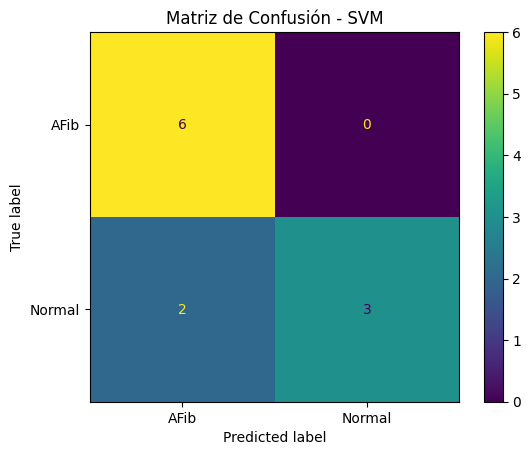

In [8]:
# visualización de la matriz de confusión
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test)
plt.title('Matriz de Confusión - SVM')
plt.show()

# Analizar brevemente los resultados obtenidos


- **AFib (verdadero):**
  - 6 fueron correctamente clasificados como Afib 
  - 0 fue incorrectamente clasificado como Normal

- **Normal (verdadero):**
  - 3 fueron correctamente clasificados como Normal (esquina inferior derecha)
  - 2 fueron clasificados erróneamente como AFib (esquina inferior izquierda)

### **Resumen:**
- El modelo acertó todos los casos Afib 6/6
- El modelo acertó 3 de 5 casos Normal y confundió 2 como Afib
- No hubo falsos negativos para AFib

### **Particularmente:**
- La detección de Normal es más débil 

- El modelo acierta en 82% de los casos aprox

- Mantiene un buen equilibrio global (F1-SCORE)

- Cuando predice AFib, lo hace bien en 86% aprox de las veces (precision_AFib = 0.8636).  



